In [1]:
!pip install contextualbandits


You should consider upgrading via the 'pip install --upgrade pip' command.


## Read The Data

In [2]:
import pandas as pd, numpy as np, re
from sklearn.preprocessing import MultiLabelBinarizer

def parse_data(file_name):
    features = list()
    labels = list()
    with open(file_name, 'rt') as f:
        f.readline()
        for l in f:
            if bool(re.search("^[0-9]", l)):
                g = re.search("^(([0-9]{1,2},?)+)\s(.*)$", l)
                labels.append([int(i) for i in g.group(1).split(",")])
                features.append(eval("{" + re.sub("\s", ",", g.group(3)) + "}"))
            else:
                l = l.strip()
                labels.append([])
                features.append(eval("{" + re.sub("\s", ",", l) + "}"))
    features = pd.DataFrame.from_dict(features).fillna(0).as_matrix()
    mlb = MultiLabelBinarizer()
    y = mlb.fit_transform(labels)
    return features, y

X, y = parse_data("Bibtex_data.txt")

## Define the models

In [48]:
from sklearn.linear_model import LogisticRegression
from contextualbandits.online import BootstrappedUCB, BootstrappedTS, SeparateClassifiers,\
            EpsilonGreedy, AdaptiveGreedy, ExploreFirst, ActiveExplorer, SoftmaxExplorer
from copy import deepcopy

nchoices = y.shape[1]
base_algorithm = LogisticRegression(random_state=123, solver='lbfgs')
beta_prior = ((3, 7), 2) # until there are at least 2 observations of each class, will use prior Beta(3, 7)

## The base algorithm is embedded in different metaheuristics
bootstrapped_ucb = BootstrappedUCB(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior)
bootstrapped_ts = BootstrappedTS(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior)
one_vs_rest = SeparateClassifiers(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior)
epsilon_greedy = EpsilonGreedy(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior)
epsilon_greedy_nodecay = EpsilonGreedy(deepcopy(base_algorithm), nchoices = nchoices,
                                     beta_prior=beta_prior, decay=None)
adaptive_greedy_thr = AdaptiveGreedy(deepcopy(base_algorithm), nchoices=nchoices,
                                     decay_type='threshold')
adaptive_greedy_perc = AdaptiveGreedy(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior,
                                      decay_type='percentile', decay=0.9997)
explore_first = ExploreFirst(deepcopy(base_algorithm), nchoices = nchoices,
                             beta_prior=None, explore_rounds=1500)
active_explorer = ActiveExplorer(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior)
adaptive_active_greedy = AdaptiveGreedy(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior,
                                        active_choice='weighted', decay_type='percentile', decay=0.9997)
softmax_explorer = SoftmaxExplorer(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior)

models_orig = [bootstrapped_ucb, bootstrapped_ts, one_vs_rest, epsilon_greedy, epsilon_greedy_nodecay,
          adaptive_greedy_thr, adaptive_greedy_perc, explore_first, active_explorer,
          adaptive_active_greedy, softmax_explorer]
      
models = [bootstrapped_ts, adaptive_greedy_thr, softmax_explorer, epsilon_greedy_nodecay]

## Helper Functions

In [54]:
#Normal Simulate round function
def simulate_rounds(model, rewards, actions_hist, X_global, y_global, batch_st, batch_end, dummy):
        np.random.seed(batch_st)

        ## choosing actions for this batch
        actions_this_batch = model.predict(X_global[batch_st:batch_end, :]).astype('uint8')
        # keeping track of the sum of rewards received
        rewards.append(y_global[np.arange(batch_st, batch_end), actions_this_batch].sum())

        # adding this batch to the history of selected actions
        new_actions_hist = np.append(actions_hist, actions_this_batch)

        # now refitting the algorithms after observing these new rewards
        np.random.seed(batch_st)
        model.fit(X_global[:batch_end, :], new_actions_hist, y_global[np.arange(batch_end), new_actions_hist])

        return new_actions_hist
    
    
#helper function for good permutation    
def random_derangement(n):
    while True:
        v = list(range(n))
        for j in range(n - 1, -1, -1):
            p = random.randint(0, j)
            if v[p] == j:
                break
            else:
                v[j], v[p] = v[p], v[j]
        else:
            if v[0] != 0:
                return tuple(v)
                
    
def simulate_mixup_better_rounds(model, rewards, actions_hist, X_global, y_global, batch_st, batch_end, new_list):
    np.random.seed(batch_st)
    orig = X_global[batch_st:batch_end, :].copy()
    index = random_derangement(batch_end-batch_st)
    shuffled = orig[index, :]
    alpha = 1
    lam = np.random.beta(alpha, alpha, size=batch_end-batch_st)
    mix_contexts = np.array([ orig[i]*lam[i] + shuffled[i]*(1-lam[i]) if lam[i]> 0.5 else orig[i]*(1-lam[i]) + shuffled[i]*(lam[i]) for i in range(batch_end-batch_st)])
    

    maj_labels = np.array([y_global[batch_st+i] for i in range(batch_end-batch_st)])
    mix_labels = np.array([y_global[batch_st+i]*lam[i] + y_global[batch_st+index[i]]*(1-lam[i]) if lam[i]> 0.5 else y_global[batch_st+i]*(1-lam[i]) + y_global[batch_st+index[i]]*lam[i] for i in range(batch_end-batch_st)])

    
    ###########
    # This part decided what to fit on
    # Change this if needed
    new_list[0].extend(mix_contexts)
    new_list[1].extend(maj_labels)
    ###########

    ## choosing actions for this batch
    actions_this_batch = model.predict(orig).astype('uint8')

    # keeping track of the sum of rewards received
    rewards.append(maj_labels[np.arange(batch_end-batch_st), actions_this_batch].sum())

    # adding this batch to the history of selected actions
    new_actions_hist = np.append(actions_hist, actions_this_batch)

    # now refitting the algorithms after observing these new rewards
    np.random.seed(batch_st)
    model.fit(np.array(new_list[0])[:batch_end, :], new_actions_hist, np.array(new_list[1])[np.arange(batch_end), new_actions_hist].astype('uint8'))

    return new_actions_hist
    
    
def simulate_mixup_rounds(model, rewards, actions_hist, X_global, y_global, batch_st, batch_end, new_list):
    np.random.seed(batch_st)
    orig = X_global[batch_st:batch_end, :].copy()
    index = np.arange(len(orig))
    np.random.shuffle(index)
    shuffled = orig[index, :]
    alpha = 1
    lam = np.random.beta(alpha, alpha, size=batch_size)
    maj_contexts = np.array([ orig[i] if lam[i]> 0.5 else shuffled[i] for i in range(batch_end-batch_st)])
    mix_contexts = np.array([ orig[i]*lam[i] + shuffled[i]*(1-lam[i]) for i in range(batch_end-batch_st)])

    maj_labels = np.array([y_global[batch_st+i] if lam[i]>0.5 else y_global[batch_st+index[i]] for i in range(batch_end-batch_st)])
    mix_labels = np.array([y_global[batch_st+i]*lam[i] + y_global[batch_st+index[i]]*(1-lam[i]) for i in range(batch_end-batch_st)])

    ###########
    # This part decided what to fit on
    # Change this if needed
    new_list[0].extend(mix_contexts)
    new_list[1].extend(mix_labels)
    ###########
    
    ## choosing actions for this batch
    actions_this_batch = model.predict(maj_contexts).astype('uint8')

    # keeping track of the sum of rewards received
    rewards.append(maj_labels[np.arange(batch_end-batch_st), actions_this_batch].sum())

    # adding this batch to the history of selected actions
    new_actions_hist = np.append(actions_hist, actions_this_batch)

    # now refitting the algorithms after observing these new rewards
    np.random.seed(batch_st)
    model.fit(np.array(new_list[0])[:batch_end, :], new_actions_hist, np.array(new_list[1])[np.arange(batch_end), new_actions_hist].astype('uint8'))

    return new_actions_hist

## Run experiments

In [55]:
# These lists will keep track of the rewards obtained by each policy
bigbig=[]
n_exp = 3
import random
for exp in range(n_exp):
    rewards_ucb, rewards_ts, rewards_ovr, rewards_egr, rewards_egr2, \
    rewards_agr, rewards_agr2, rewards_efr, rewards_ac, \
    rewards_aac, rewards_sft = [list() for i in range(len(models_orig))]

    lst_rewards = [rewards_ucb, rewards_ts, rewards_ovr, rewards_egr, rewards_egr2,
                   rewards_agr, rewards_agr2, rewards_efr, rewards_ac,
                   rewards_aac, rewards_sft]

    # batch size - algorithms will be refit after N rounds
    batch_size=50

    # initial seed - all policies start with the same small random selection of actions/rewards
    first_batch = X[:batch_size, :]
    action_chosen = np.random.randint(nchoices, size=batch_size)
    rewards_received = y[np.arange(batch_size), action_chosen]

    # fitting models for the first time
    for model in models:
        np.random.seed(123)
        model.fit(X=first_batch, a=action_chosen, r=rewards_received)

    # these lists will keep track of which actions does each policy choose
    lst_a_ucb, lst_a_ts, lst_a_ovr, lst_a_egr, lst_a_egr2, lst_a_agr, \
    lst_a_agr2, lst_a_efr, lst_a_ac, lst_a_aac, \
    lst_a_sft = [action_chosen.copy() for i in range(len(models_orig))]

    lst_actions = [lst_a_ucb, lst_a_ts, lst_a_ovr, lst_a_egr, lst_a_egr2, lst_a_agr,
                   lst_a_agr2, lst_a_efr, lst_a_ac, lst_a_aac, lst_a_sft]
    
    new_lists = [list(first_batch), list(y[:batch_size, :])]
    for i in range(int(np.floor(X.shape[0] / batch_size))):
        batch_st = (i + 1) * batch_size
        batch_end = (i + 2) * batch_size
        batch_end = np.min([batch_end, X.shape[0]])
        
        if i%10==0:
                print("Exp no: ", exp, ", Training batch: ", i)
        for model in range(len(models)):
            lst_actions[model] = simulate_rounds(models[model],
                                                 lst_rewards[model],
                                                 lst_actions[model],
                                                 X, y,
                                                 batch_st, batch_end, new_lists)
    bigbig.append(lst_rewards)

Exp no:  0 , Training batch:  0
Exp no:  0 , Training batch:  10
Exp no:  0 , Training batch:  20
Exp no:  0 , Training batch:  30
Exp no:  0 , Training batch:  40
Exp no:  0 , Training batch:  50
Exp no:  0 , Training batch:  60
Exp no:  0 , Training batch:  70
Exp no:  0 , Training batch:  80
Exp no:  0 , Training batch:  90
Exp no:  0 , Training batch:  100
Exp no:  0 , Training batch:  110
Exp no:  0 , Training batch:  120
Exp no:  0 , Training batch:  130
Exp no:  0 , Training batch:  140
Exp no:  1 , Training batch:  0
Exp no:  1 , Training batch:  10
Exp no:  1 , Training batch:  20
Exp no:  1 , Training batch:  30
Exp no:  1 , Training batch:  40
Exp no:  1 , Training batch:  50
Exp no:  1 , Training batch:  60
Exp no:  1 , Training batch:  70
Exp no:  1 , Training batch:  80
Exp no:  1 , Training batch:  90
Exp no:  1 , Training batch:  100
Exp no:  1 , Training batch:  110
Exp no:  1 , Training batch:  120
Exp no:  1 , Training batch:  130
Exp no:  1 , Training batch:  140
Ex

## Save reward logs

In [56]:
import numpy as np
np.save("3_147_standard", bigbig)

## Visualize rewards

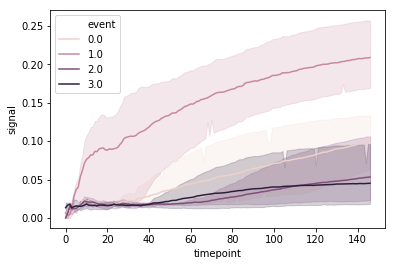

In [52]:
import seaborn as sns
import pandas as pd

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

df = pd.DataFrame({'timepoint':[], 'event':[], 'signal':[]})
bignew = []
for i in bigbig:
    curves = []
    for j in i:
        curve = get_mean_reward(j)
        curves.append(curve)
    bignew.append(curves)
np.array(bignew).shape

for i, exp in enumerate(bignew):
    for j, algo in enumerate(exp):
        for k, reward in enumerate(algo):
            df2 = pd.DataFrame({'timepoint':[k], 'event':[j], 'signal':[reward]})
            df=df.append(df2)
df

ax = sns.lineplot(x="timepoint", y="signal", hue="event",
                  data=df)

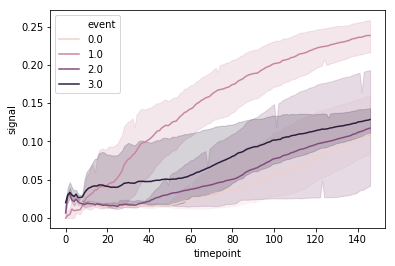

In [57]:
import seaborn as sns
import pandas as pd

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

df = pd.DataFrame({'timepoint':[], 'event':[], 'signal':[]})
bignew = []
for i in bigbig:
    curves = []
    for j in i:
        curve = get_mean_reward(j)
        curves.append(curve)
    bignew.append(curves)
np.array(bignew).shape

for i, exp in enumerate(bignew):
    for j, algo in enumerate(exp):
        for k, reward in enumerate(algo):
            df2 = pd.DataFrame({'timepoint':[k], 'event':[j], 'signal':[reward]})
            df=df.append(df2)
df

ax = sns.lineplot(x="timepoint", y="signal", hue="event",
                  data=df)